<Figure size 800x400 with 0 Axes>

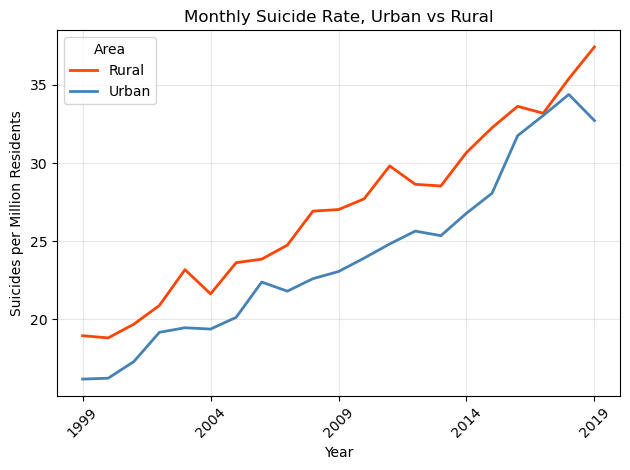

<Figure size 800x400 with 0 Axes>

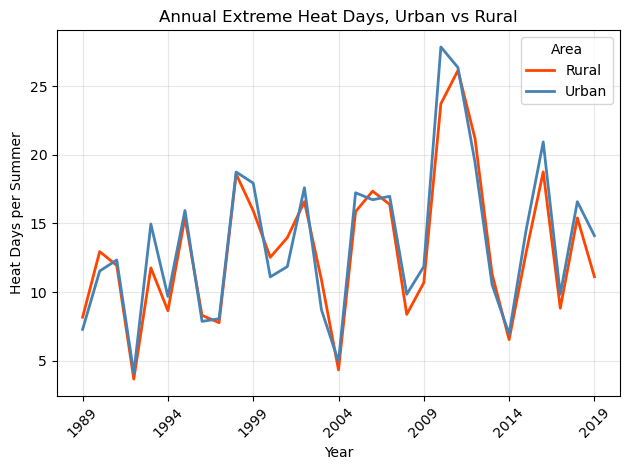

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
output_path_1 = (BASE_DIR / "Monthly Suicide Rate.png").resolve()
output_path_2 = (BASE_DIR / "EHDs.png").resolve()
analysis_path = (BASE_DIR / ".." /  "Analysis" / "Analysis_Data" / "analysis_data.csv").resolve()




df = pd.read_csv(
    analysis_path,
    dtype={
        "fips_standard": str, "Urban": int, "year": int, "month": int,
        "Attribute": str, "Deaths": int, "Population": int,
        "rate_per_million": float, "EHDs": int
    }
)


df_suicide = df.query("Attribute == 'Total'") 

suicide_group = (
    df_suicide
    .groupby(["year", "Urban"], as_index=False)["rate_per_million"]
    .mean()
)

suicide_group = suicide_group[suicide_group["year"] >= 1999]

plot_df = suicide_group.pivot(index="year", columns="Urban", values="rate_per_million")
plot_df.columns = ["Rural", "Urban"]

plt.figure(figsize=(8,4))
plot_df.plot(linewidth=2, color=["orangered", "steelblue"])
plt.title("Monthly Suicide Rate, Urban vs Rural")
plt.ylabel("Suicides per Million Residents")
plt.xlabel("Year")
plt.xticks(plot_df.index, rotation=45)
plt.legend(title="Area")
plt.grid(alpha=0.3)
plt.xticks(ticks=np.arange(1999, 2020, 5), rotation=45)  
plt.tight_layout()
plt.savefig(output_path_1, dpi=300)
plt.show()

annual_ehd = (
    df_suicide
    .groupby(["year","fips","Urban"], as_index=False)["EHDs"]
    .sum()
)

ehd_group = (
    annual_ehd
    .groupby(["year","Urban"], as_index=False)["EHDs"]
    .mean()
)

ehd_plot = ehd_group.pivot(index="year", columns="Urban", values="EHDs")
ehd_plot.columns = ["Rural","Urban"]

plt.figure(figsize=(8,4))
ehd_plot.plot( linewidth=2,  color=["orangered", "steelblue"])
plt.title("Annual Extreme Heat Days, Urban vs Rural")
plt.ylabel("Heat Days per Summer")
plt.xlabel("Year")
plt.xticks(ehd_plot.index, rotation=45)
plt.legend(title="Area")
plt.grid(alpha=0.3)
plt.xticks(ticks=np.arange(1989, 2020, 5), rotation=45)  
plt.tight_layout()
plt.savefig(output_path_2, dpi=300)
plt.show()


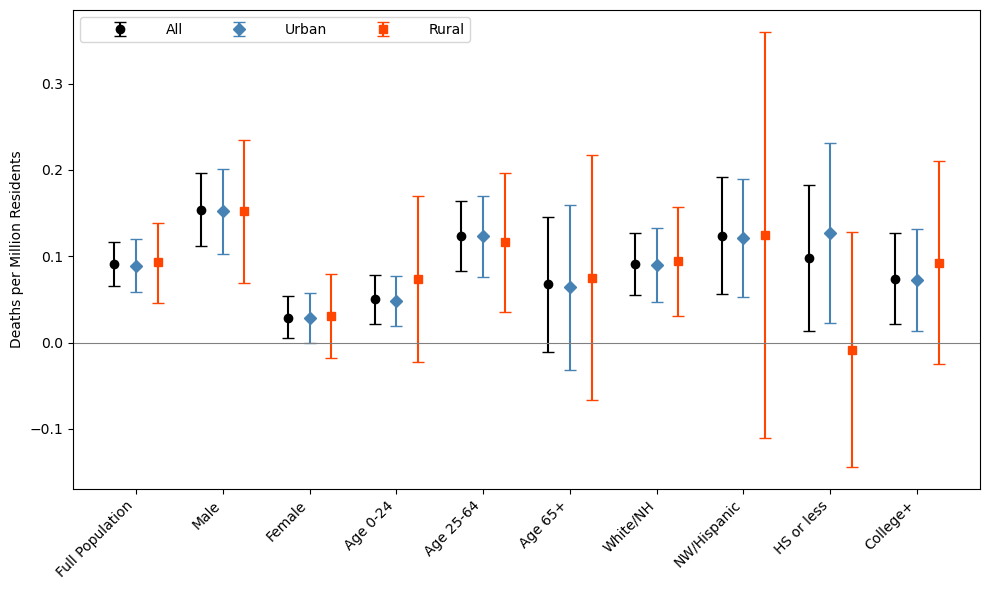

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
csv_path = (BASE_DIR / ".."  / "Analysis" / "lin_regression_summary.csv").resolve()
output_path = (BASE_DIR / "lin_results.png").resolve()

df = pd.read_csv(csv_path)

styles = {
    "All":   {"color": "black",    "marker": "o"},
    "Urban": {"color": "steelblue",  "marker": "D"},
    "Rural": {"color": "orangered",   "marker": "s"},
}

subgroups = df["Subgroup"].unique().tolist()
x_pos     = np.arange(len(subgroups))
width     = 0.25  

fig, ax = plt.subplots(figsize=(10, 6))

for idx, region in enumerate(["All", "Urban", "Rural"]):
    style  = styles[region]
    sub_df = (
        df[df["Region"] == region]
          .set_index("Subgroup")
          .reindex(subgroups)   
    )
    offsets = (idx - 1) * width
    xs      = x_pos + offsets

    ys          = sub_df["Estimate"].values
    lower_err   = ys - sub_df["CI_low.2.5 %"].values
    upper_err   = sub_df["CI_high.97.5 %"].values - ys
    yerr        = np.vstack([lower_err, upper_err])

    ax.errorbar(
        xs, ys, yerr=yerr,
        fmt=style["marker"],
        color=style["color"],
        ecolor=style["color"],
        capsize=4,
        label=region,
        linestyle="none",
        markersize=6,
    )



ax.axhline(0, color="gray", linewidth=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(subgroups, rotation=45, ha="right")
ax.set_ylabel("Deaths per Million Residents")
ax.legend(
    loc="upper left",
    ncol=3,             
    handlelength=5,    
    columnspacing=1.5,  
    fontsize="medium",
    frameon=True,       
)
plt.tight_layout()

plt.savefig(output_path, dpi=300)

plt.show()


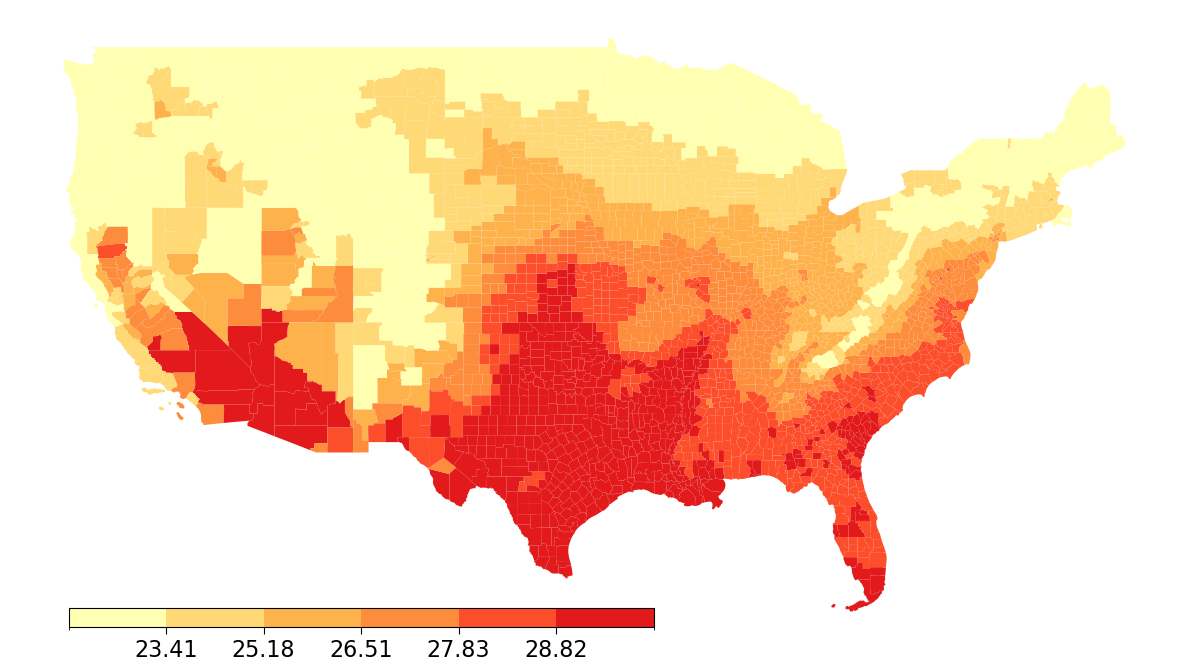

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
county_path = (BASE_DIR / ".."  / "Data" / "Counties_Boundaries" / "tl_2019_us_county" / "tl_2019_us_county.shp").resolve()
threshold_path =(BASE_DIR / ".." / "Data" / "Temperature" / "final_85th_percentile_thresholds.csv")
output_path = (BASE_DIR / "thresholds.png").resolve()

counties = gpd.read_file(county_path)

thresholds = pd.read_csv(
    threshold_path,
    dtype={"GEOID": str, "month": int, "EHD_threshold": float}
)

thresholds['GEOID'] = thresholds['GEOID'].astype(str).str.zfill(5)

avg_thresholds = thresholds.groupby('GEOID', as_index=False)['EHD_threshold'].mean()

num_bins = 6
avg_thresholds['quantile_bin'], bin_edges = pd.qcut(
    avg_thresholds['EHD_threshold'],
    q=num_bins,
    retbins=True,
    precision=2,
    duplicates='drop'
)

bin_labels = [f"{bin_edges[i]:.2f}–{bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)]

avg_thresholds['quantile_bin'] = pd.qcut(
    avg_thresholds['EHD_threshold'],
    q=num_bins,
    labels=bin_labels,
    precision=2,
    duplicates='drop'
)

counties['GEOID'] = counties['GEOID'].astype(str).str.zfill(5)
counties = counties.merge(avg_thresholds[['GEOID', 'quantile_bin']], on='GEOID', how='left')

excluded_fips = ['02', '15', '60', '66', '69', '72', '78']
continental = counties[~counties['STATEFP'].isin(excluded_fips)]

colors = ['#ffffb2', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c']
cmap = ListedColormap(colors[:len(bin_labels)])

fig, ax = plt.subplots(figsize=(12, 8))
continental.plot(column='quantile_bin',
                 cmap=cmap,
                 linewidth=0,
                 edgecolor='none',
                 legend=False,
                 ax=ax)

ax.set_axis_off()


norm = mpl.colors.BoundaryNorm(bin_edges, len(colors))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm,
                    ax=ax,
                    orientation='horizontal',
                    location='bottom',
                    anchor=(0.1, 1.5), 
                    shrink=0.5,
                    pad=0.02,
                    aspect=30)

tick_positions = bin_edges[1:-1]
tick_labels = [f"{x:.2f}" for x in tick_positions]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=16, length=5)


plt.tight_layout()
plt.savefig(output_path, dpi=300)

plt.show()


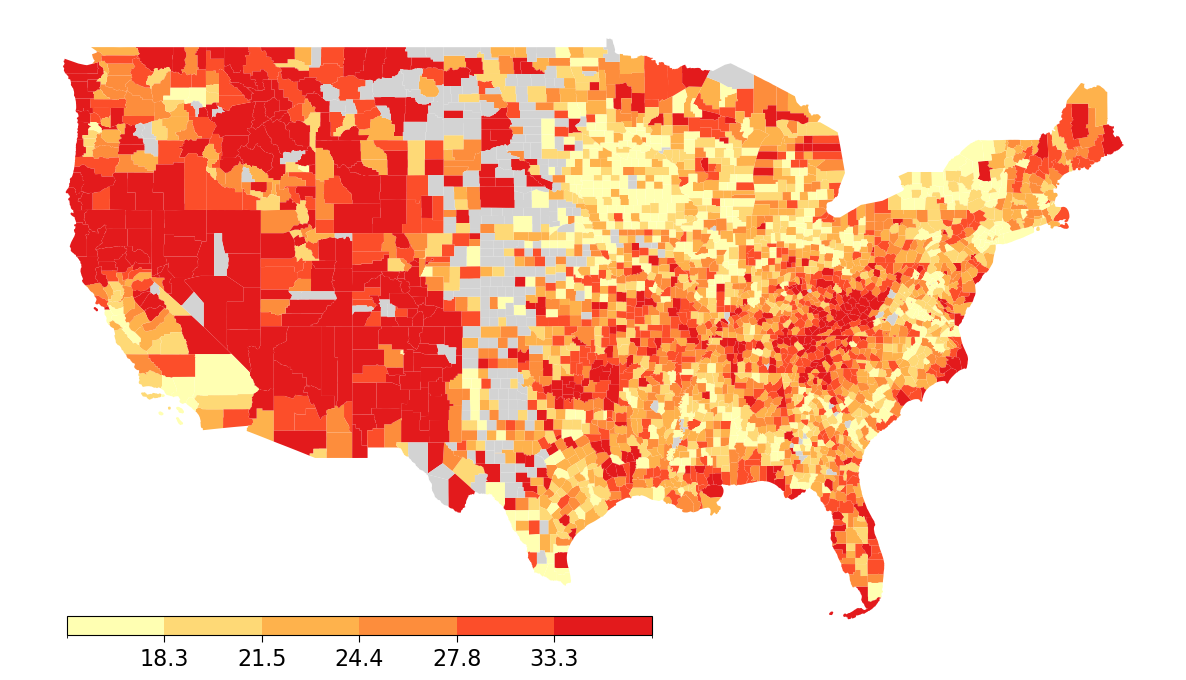

In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from pathlib import Path

BASE_DIR = Path.cwd().resolve()
county_path = (BASE_DIR / ".."  / "Data" / "Counties_Boundaries" / "tl_2019_us_county" / "tl_2019_us_county.shp").resolve()
analysis_path = (BASE_DIR / ".." /  "Analysis" / "Analysis_Data" / "analysis_data.csv").resolve()
output_path = (BASE_DIR / "suicide map.png").resolve()

counties = gpd.read_file(county_path)

counties['GEOID'] = counties['GEOID'].astype(str).str.zfill(5)

data = pd.read_csv(
    analysis_path,
    dtype={'fips': str, 'year': int, 'month': int}
)

data = data[data['Attribute'] == 'Total'].copy()
data['fips'] = data['fips'].str.zfill(5)

death_sums = data.groupby('fips')['Deaths'].sum().reset_index()
valid_fips = death_sums[death_sums['Deaths'] >= 10]['fips']
data = data[data['fips'].isin(valid_fips)]

avg_rates = data.groupby('fips', as_index=False)['rate_per_million'].mean()

counties = counties.merge(avg_rates, left_on='GEOID', right_on='fips', how='left')

excluded_fips = ['02', '15', '60', '66', '69', '72', '78']
continental = counties[~counties['STATEFP'].isin(excluded_fips)].copy()

num_bins = 6
valid_data = continental[continental['rate_per_million'].notna()].copy()
valid_data['quantile_bin'], bin_edges = pd.qcut(
    valid_data['rate_per_million'],
    q=num_bins,
    retbins=True,
    precision=1,
    duplicates='drop'
)

bin_labels = [f"{bin_edges[i]:.1f}–{bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]
valid_data['quantile_bin'] = pd.qcut(
    valid_data['rate_per_million'],
    q=num_bins,
    labels=bin_labels,
    precision=1,
    duplicates='drop'
)

continental = continental.set_index('GEOID')
valid_data = valid_data.set_index('GEOID')
continental.loc[valid_data.index, 'quantile_bin'] = valid_data['quantile_bin']
continental = continental.reset_index()

colors = ['#ffffb2', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c']
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(12, 8))
continental.plot(column='quantile_bin',
                 cmap=cmap,
                 linewidth=0,
                 edgecolor='none',
                 legend=False,
                 ax=ax,
                 missing_kwds={
                     "color": "lightgray",
                     "label": "NR"
                 })

ax.set_axis_off()

import matplotlib as mpl

norm = mpl.colors.BoundaryNorm(bin_edges, len(colors))
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm,
                    ax=ax,
                    orientation='horizontal',
                    location='bottom',
                    anchor=(0.1, 1.5),     
                    shrink=0.5,              
                    pad=0.02,                
                    aspect=30)

tick_positions = bin_edges[1:-1]
tick_labels = [f"{x:.1f}" for x in tick_positions]

cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=16, length=5)

plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()
